In [ ]:
# эта строчка исключительно для моей директории в колабе - не запускать при работе на локале
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# эта строчка исключительно для моей директории в колабе - не запускать при работе на локале
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/ozon')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/ozon'

<div class="alert alert-info">
В одной директории с .ipynb воркбуком должны быть файлы:
     <strong> Test (SQL + Python)-1.ipynb; </strong>
     <strong> test2.xlsx; </strong>
     <strong> titanic.csv; </strong>
     <strong> Titanic_hist.png; </strong>
     <strong> Titanic_SR.png; </strong>
     <strong> Шаблон 101.docx. </strong>
</div>

<div class="alert alert-danger"> Итоговый воркбук должен быть исполняем <strong> AS IS </strong> при наличии всех датасет файлов в директории. Фэйл исполнения == фэйл задания. </div>

# Подготовка

In [ ]:
!pip install pandas

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('titanic.csv')

In [ ]:
# Проверь, что база загрузилась и читается
df

Это датафрейм "Титаник" с информацией о пассажирах на борту корабля:
- Survived = 1/0 (1 = выжил при крушении / 0 = нет)
- Pclass = класс, которым ехал пассажир (1 - наилучший)
- Name = имя пассажира
- Sex = пол пассажира
- Age = возраст пассажира
- Siblings/Spouses Aboard = Кол-во братьев/сестер/супругов на борту у пассажира
- Parents/Children Aboard = Кол-во родителей/детей на борту у пассажира
- Fare = стоимость билета

# SQL

In [ ]:
# Проверь, что запрос выполняется и возвращает 487 записей
!pip install sqldf

In [ ]:
import sqldf

In [ ]:
df = pd.read_csv('titanic.csv')

In [ ]:
df

In [ ]:
query = 'Select count(distinct Name) as nmb from df where Pclass = 3'
sqldf.run(query)

Далее нужно написать запросы на SQL, которые отвечают на вопрос из задания

### Task 1

1.1. Есть ли выжившие пассажиры возрастом от 20 до 30 лет, одного пола, летевшие одним классом?
Вывести группы и кол-во пассажиров в них

1.2. А есть ли выжившие пассажиры возрастом от 20 до 30 лет, одного пола, летевшие одним классом, у которых средняя стоимость билета отклоняется не более, чем на 10% от средней цены билета по всем пассажирам.
Вывести группы, кол-во пассажиров в них, среднюю цену билета в группе и среднюю цену билета по всем пассажирам

In [ ]:
# 1.1
query = '''
SELECT Sex, Pclass, count(*) FROM df
WHERE Survived = 1 and Age >= 20 and Age <= 30
GROUP BY Sex, Pclass
HAVING count(*) > 1
'''
sqldf.run(query)

,Sex,Pclass,count(*)
0,female,1,21
1,female,2,25
2,female,3,30
3,male,1,10
4,male,2,2
5,male,3,20


In [ ]:
# 1.2 ч1
# здесь не работают подзапросы, поэтому приходится устраивать натуральный цирк. и вообще это не честно.
def costil_avg() -> int:
  query = 'SELECT avg(Fare) as avg_fair FROM df'
  return sqldf.run(query).avg_fair.values[0]

df_avg_fare = pd.DataFrame({'value': [costil_avg()]}) # CREATE TABLE, INSERT и все все все тоже не работает - это нечестно

In [ ]:
df_avg_fare # check

,value
0,32.30542


In [ ]:
# 1.2 ч2
query = '''
SELECT Sex, Pclass, count(*), avg(Fare) as group_avg_fare, df_avg_fare.value as avg_fare
FROM df
JOIN df_avg_fare
WHERE Survived = 1 and Age >= 20 and Age <= 30  and (Fare <= 1.1 * avg_fare and Fare >= 0.9 * avg_fare)
GROUP BY Sex, Pclass
HAVING count(*) > 1
'''
sqldf.run(query)

,Sex,Pclass,count(*),group_avg_fare,avg_fare
0,male,1,4,31.425,32.30542


### Task 2

2. Сколько пассажиров летело в возрасте 0-19, 20-29, 30-39, 40-49 и 50+ лет каждого пола,
посчитать долю каждой группы от общего числа пассажиров и среднюю стоимость билета для каждой группы?
(округление может некорректно отрабатывать, оставить округление до целых)

In [ ]:
#2
# опять костылим
def costil_cnt() -> int:
  query = 'SELECT count(*) as cnt FROM df'
  return sqldf.run(query).cnt.values[0]

df_cnt = pd.DataFrame({'value': [costil_cnt()]})

# > округление может некорректно отрабатывать, оставить округление до целых
# я так понял, имеется в виду использование FLOOR() округления. если имелся в виду round - я бы передалал. но уточнить не имею возможности

query = '''
SELECT
  CASE
    WHEN Age < 20 THEN '0-19'
    WHEN Age < 30 THEN '20-29'
    WHEN Age < 40 THEN '30-39'
    WHEN Age < 50 THEN '40-49'
    WHEN Age >= 50 THEN '50+'
  END AS custom,
  Sex,
  count(*), CAST(count(*) AS FLOAT) / df_cnt.value as fraction, FLOOR(avg(Fare))
FROM df
JOIN df_cnt
GROUP BY custom, Sex

'''
sqldf.run(query)

,custom,Sex,count(*),fraction,FLOOR(avg(Fare))
0,0-19,female,89,0.100338,34.0
1,0-19,male,110,0.124014,26.0
2,20-29,female,92,0.103720,35.0
3,20-29,male,201,0.226607,18.0
4,30-39,female,68,0.076663,54.0
5,30-39,male,131,0.147689,27.0
6,40-49,female,42,0.047351,59.0
7,40-49,male,72,0.081172,32.0
8,50+,female,23,0.025930,64.0
9,50+,male,59,0.066516,35.0


### Task 3

3. Посчитать кол-во пассажиров, обращение к которым указано как "Mrs" и аналогично для "Miss". Вывести так же максимальный, минимальный и средний возраст для групп

In [ ]:
query = '''
SELECT
  CASE
    WHEN instr(Name, 'Miss') <> 0 THEN 'Miss'
    WHEN instr(Name, 'Mrs') <> 0 THEN 'Mrs'
    ELSE NULL
  END AS prefix,
  count(*), max(Age), min(Age), avg(Age)
FROM df
WHERE prefix IS NOT NULL
GROUP BY prefix

'''
sqldf.run(query)

,prefix,count(*),max(Age),min(Age),avg(Age)
0,Miss,182,63.0,0.75,21.994505
1,Mrs,125,63.0,14.00,35.768000


# Python

In [ ]:
file = 'test2.xlsx'
df = pd.read_excel(file, engine='openpyxl')

In [ ]:
# Проверь, что база загрузилась и читается
df

Это датафрейм с заявками на кредит и решением для них: одобрить или отказать, а так же причина отказа.
- loan_id = номер заявки
- app_status = решение по заявке (одобрить или отказать)
- reason = номер причины отказа (по одной заявке может срабатывать несколько причин)

Далее нужно написать код на Python, которые отвечают на вопрос из задания

### Task 4

In [ ]:
# 1. Посчитать Approval Rate (кол-во одобренных анкет ко всем) в % и вывести кол-во одобренных анкет (approved уникальны, decline - нет)
print('Approved app count, num')
print(df[df['app_status'] == 'approved'].drop_duplicates('loan_id').app_status.count())
print('Approval Rate, %')
print(100 * float(df[df['app_status'] == 'approved'].app_status.count()) / float(df.drop_duplicates('loan_id').app_status.count()))

Approved app count, num
353
Approval Rate, %
62.47787610619469


In [ ]:
# print('Approval Rate, %')
# print(df.drop_duplicates('loan_id').app_status.value_counts(normalize=True).mul(100).head(1)) # - типо с ума сойти решил

In [ ]:
# 2. Посчитать кол-во отказных анкет и вывести % срабатывания каждого правила относительно всех отказов? Какие 3 правила чаще всего срабатывают в отказах?
print('Approved app count, num')
print(df[df['app_status'] == 'declined'].drop_duplicates('loan_id').app_status.count())
df[df['app_status'] == 'declined'].reason.value_counts(normalize=True).mul(100)  # оказалось тут понадобилось, не зря старался

Approved app count, num
212


reason
Rule5     11.801242
Rule6     11.387164
Rule8     10.973085
Rule7     10.973085
Rule3     10.559006
Rule4     10.351967
Rule2      9.730849
Rule10     8.488613
Rule9      7.867495
Rule1      7.660455
Rule11     0.207039
Name: proportion, dtype: float64

In [ ]:
# df[df['app_status'] == 'declined'].reason.value_counts(normalize=True).mul(100).head(3) - топ 3

### Task 5

В датафрейме ниже лежат данные по клиентам и их задолженности:
- Numb = номер записи (= номер документа)
- Client = имя клиента
- OSZ = Сумма задолженности
- peny = пени

In [ ]:
df_docx = {
    'Numb':[102,103,104],
    'Client':['БББ.Б.Б','ВВВВВ.В','ГГ.Г.ГГ'],
    'OSZ':[1200000, 500000, 3000000],
    'peny':[1500,1000,2500]
}

In [ ]:
df_docx = pd.DataFrame(df_docx)

In [ ]:
df_docx

,Numb,Client,OSZ,peny
0,102,БББ.Б.Б,1200000,1500
1,103,ВВВВВ.В,500000,1000
2,104,ГГ.Г.ГГ,3000000,2500


В файле Шаблон.docx нужно заменить выделенные данные на данные датафрема выше и сохранить новые файлы (один файл - под каждую запись, исходный файл не затирать, сохранить форматирование сумм в рублях)

In [ ]:
!pip install python-docx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 2.9 MB/s eta 0:00:00


In [ ]:
import docx
import os

In [ ]:
os.makedirs('5', exist_ok=True)

In [ ]:
# открываем
doc = docx.Document('Шаблон 101.docx')

# 102
# изменяем
doc.paragraphs[0].runs[1].text = str(df_docx['Numb'][0])
doc.paragraphs[1].runs[1].text = str(df_docx['Client'][0])
doc.paragraphs[2].runs[1].text = str(df_docx['OSZ'][0])
doc.paragraphs[2].runs[3].text = str(df_docx['peny'][0])

#сохраняем
doc.save('5/Шаблон 102.docx')

# 103
# изменяем
doc.paragraphs[0].runs[1].text = str(df_docx['Numb'][1])
doc.paragraphs[1].runs[1].text = str(df_docx['Client'][1])
doc.paragraphs[2].runs[1].text = str(df_docx['OSZ'][1])
doc.paragraphs[2].runs[3].text = str(df_docx['peny'][1])
doc.save('5/Шаблон 103.docx')

# сохраняем
doc = docx.Document('5/Шаблон 103.docx')

# 104
# изменяем
doc.paragraphs[0].runs[1].text = str(df_docx['Numb'][2])
doc.paragraphs[1].runs[1].text = str(df_docx['Client'][2])
doc.paragraphs[2].runs[1].text = str(df_docx['OSZ'][2])
doc.paragraphs[2].runs[3].text = str(df_docx['peny'][2])

# сохраняем
doc.save('5/Шаблон 104.docx')

# p.s. да, без цикла было удобнее

### Task 6

Используя датасет titanic.csv создать визуализацию в виде нормированной гистограммы отражающую распределение выживших пассажиров (мужчин и женщин) по возрастам с шагом в 5 лет, при этом исключить из выборки тех кто старше 60 и тех кто младше 5. При этом на одну картинку вывести в т.ч. Total по выборке.

Ответом будет служить картинка вида (+ python код который эту визуализацию строит):

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('titanic.csv')

In [ ]:
df_surv = df[df['Survived'] == 1].drop(['Pclass', 'Name', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare'], axis=1)

# df_surv["age_group"] = pd.cut(df_surv["Age"], [np.arange(0, 60, 5), 60, 61, np.inf], labels=[np.arange(0, 60, 5), 60, 61])
df_surv["age_group"] = pd.cut(df_surv["Age"], list(np.arange(0, 61, 5)) + [61] + [np.inf], labels=list(np.arange(0, 61, 5)) + [61]) # выбросить старше 60(т.е <61)
# drop value 0, 61 agegroups #todo
df_surv = df_surv[df_surv["age_group"] > 0]
df_surv = df_surv[df_surv["age_group"] < 61]
# drop columns, male/female partition
var_male = df_surv[df_surv['Sex'] == 'male'].drop(['Age', 'Survived', 'Sex'], axis=1).sort_values(["age_group"]).value_counts(sort=False, normalize=True).mul(100)
var_female = df_surv[df_surv['Sex'] == 'female'].drop(['Age', 'Survived', 'Sex'], axis=1).sort_values(["age_group"]).value_counts(sort=False, normalize=True).mul(100)
var_total = df_surv.drop(['Age', 'Survived', 'Sex'], axis=1).sort_values(["age_group"]).value_counts(sort=False, normalize=True).mul(100)

In [ ]:
var_male # действительно выкинул

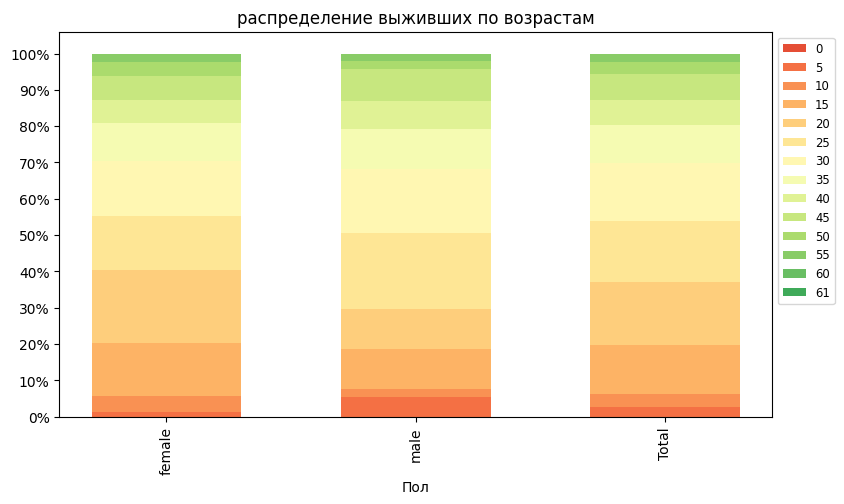

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

category_names = [var_total.index.values[i][0] for i in range(len(var_total.index.values))] # крайне очевидная типизация
results = {
  'female': var_female.values,
  'male': var_male.values,
  'Total': var_total.values
}

def survey(results, category_names):
  labels = list(results.keys())
  data = np.array(list(results.values()))
  data_cum = data.cumsum(axis=1)
  category_colors = plt.colormaps['RdYlGn'](
      np.linspace(0.15, 0.85, data.shape[1]))

  fig, ax = plt.subplots(figsize=(9.2, 5))

  ax.set_ylim(ymax=106)

  y_formatter = matplotlib.ticker.PercentFormatter()
  ax.yaxis.set_major_formatter(y_formatter)

  for i, (colname, color) in enumerate(zip(category_names, category_colors)):
      widths = data[:, i]
      starts = data_cum[:, i] - widths
      ax.bar(labels, widths, bottom=starts, width=0.6,
                      label=colname, color=color)
  ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='small') # легенда

  return fig, ax

survey(results, category_names)

plt.title('распределение выживших по возрастам')
plt.xlabel('Пол')

plt.xticks(rotation=90)
plt.yticks(np.arange(0, 101, 10))

plt.show()

![Titanic](Titanic_hist.png)

Используя датасет titanic.csv вывести таблцу Survival Rate для мужчин и для женщин старше 20 лет. Полученную таблицу записать в файл формата .xlsx.


Ответом будет служить .xlsx (+ python код который эту визуализацию строит) файл с записанным в него результатом:

![Titanic_sr](Titanic_SR.png)

In [ ]:
df = pd.read_csv('titanic.csv')

In [ ]:
os.makedirs('6', exist_ok=True)

In [ ]:
# про реализацию A столбца индексами не было ни слова, так что сделаю просто строчкой
# df_xlsx = pd.DataFrame()

df_6 = df[df['Age'] >= 20].drop(['Pclass', 'Name', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare'], axis=1) # условие на выбор возраста сформулированно некорректно. по условию неравенство "страше 20" = >20 - строгое - пришлось подогнать под цифы.

def get_table(df) -> dict:
  df_male = df[df['Sex'] == 'male']
  df_female = df[df['Sex'] == 'female']
  male_dead, male_surv = df_male.sort_values(['Survived'])['Survived'].value_counts(normalize=True, sort=False).values
  female_dead, female_surv = df_female.sort_values(['Survived'])['Survived'].value_counts(normalize=True, sort=False).values
  total_dead, tota_surv = df.sort_values(['Survived'])['Survived'].value_counts(normalize=True, sort=False).values
  total_val = 1
  return {
      'Sex': ['female', 'male', 'total'],
      'RIP': [female_dead, male_dead, total_dead],
      'Survived': [female_surv, male_surv, tota_surv],
      'Total': [total_val, total_val, total_val]
  }
ans_dict = get_table(df_6)
df_xlsx = pd.DataFrame(data=ans_dict)

# write dataframe to excel
df_xlsx.to_excel(r'6/output2.xlsx', index=False)
df_xlsx

,Sex,RIP,Survived,Total
0,female,0.226667,0.773333,1
1,male,0.829374,0.170626,1
2,total,0.632267,0.367733,1


In [ ]:
!pip install openpyxl

In [ ]:
import openpyxl
from openpyxl.formatting.rule import ColorScaleRule
wb = openpyxl.load_workbook('6/output2.xlsx')

In [ ]:
ws = wb['Sheet1']
tmp = ws['C3'].value
for i in ['B2', 'B3', 'B4', 'C2', 'C3', 'C4', 'D2', 'D3', 'D4']:
  ws[i].number_format = '0.0%'


rule_asc = ColorScaleRule(start_type='percentile', start_value=0, start_color='00AA00',
                      mid_type='percentile', mid_value=50, mid_color='FFFFFF',
                      end_type='percentile', end_value=100, end_color='DC143C')
rule_desc = ColorScaleRule(start_type='percentile', start_value=0, start_color='DC143C',
                      mid_type='percentile', mid_value=50, mid_color='FFFFFF',
                      end_type='percentile', end_value=100, end_color='00AA00')
ws.conditional_formatting.add('B2:C4', rule_asc)
ws.conditional_formatting.add('D2:D4', rule_desc)

wb.save('6/output2.xlsx')
wb.close()

### Task 7

Используя датасет построить корреляцию между возрастом, полом и Survival Rate'ом пассажиров титаника, визуализовать это в виде кривых и описать полученные результаты в виде краткой аналитической записки.

In [ ]:
# я уже просто тороплюсь, надеюсь я вообще правильно понял задание
df = pd.read_csv('titanic.csv')

# set age_group step
step = 4

# age group split
df_7 = df.sort_values(['Age'])
df_7['age_group'] = pd.cut(df_7["Age"], list(np.arange(0, 90, step)) + [np.inf], labels=np.arange(0, 90, step))

# drop age col
df_7 = df_7.drop(['Age'], axis=1)

# drop cols
df_7_male = df_7[df_7['Sex'] == 'male'].drop(['Pclass', 'Name', 'Sex', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare'], axis=1)
df_7_female = df_7[df_7['Sex'] == 'female'].drop(['Pclass', 'Name', 'Sex', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare'], axis=1)
df_7 = df_7.drop(['Pclass', 'Name', 'Sex', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare'], axis=1)


# groupby, calculate survrate
df_7_male = df_7_male.groupby(['age_group']).mean()
df_7_female = df_7_female.groupby(['age_group']).mean()
df_7 = df_7.groupby(['age_group']).mean()

In [ ]:
# check field
# type(df_7)
# np.array(df_7.index.values)
# df_7

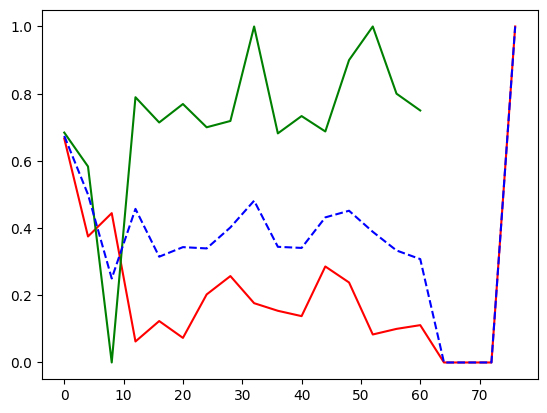

In [ ]:
# графики
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

xs = np.array(df_7.index.values)
xs_fem = np.array(df_7_female.index.values)
ys_male = df_7_male['Survived']
ys_female = df_7_female['Survived']
ys_total = df_7['Survived']

# пацаны красный, девки зеленый, общий - синий пунктир
plt.plot(xs, ys_male, 'r', xs_fem, ys_female, 'g', xs, ys_total, '--b')
plt.show()

In [ ]:
# ну корреляцию тут можно только по ворзастным группам ловить.
# во первых забыть про age > 60 вообще, там данные на выбросах

# age > 10: кореллеция по полам:
# прямая для female, survrate
# обратная для male, survrate

# еще можно сову на глобус натянуть, но там с шагом скорее всего совпало
# age < 10: обратная корреляция survrate, age - независимо от пола (т.е. как для мужчин женщин по отдельности, так и в целом)

In [ ]:
df[df['Sex'] == 'female'].sort_values(['Age']).tail(40) # пожилых мадам за 70 в датасете нема, разные длины массивов словил